In [33]:
import pandas as pd
from ultralytics import YOLO
from utils.autocomplete.yolo_utils import get_meta, search_pdf_by_path
from utils.autocomplete import yolo_utils as yolo
import json
from pathlib import Path


from tqdm import tqdm
tqdm.pandas()
%matplotlib inline

In [34]:
PATH_TO_DETECT_PDF = '/local_data/clear_full/'
# CLASSES = ['predict_content', 'predict_date', 'predict_number', 'predict_sender', 'predict_signer']
model_predict_classes = YOLO('/local_data/models/model_yolo_5_classes.pt')
model_content = YOLO('/local_data/models/model_content.pt')

In [13]:
df_meta = get_meta(PATH_TO_DETECT_PDF)

100%|██████████| 9528/9528 [00:08<00:00, 1188.14it/s]


In [29]:
df_meta.files.iloc[0]

[{'name': 'pr_2253_viersiia_2.pdf',
  'id': '7d9222af-ed6c-4f0b-be0a-43c63f5907f5',
  'extension': '.pdf',
  'importance': 0,
  'order': 0,
  'size': 180542,
  'is_signed': True,
  'save_name': '7d9222af-ed6c-4f0b-be0a-43c63f5907f5.pdf'},
 {'name': 'pr_2253_viersiia_2_файл_отображения (1).pdf',
  'id': '01ac4028-460d-4a35-a884-5a12df724921',
  'extension': '.pdf',
  'importance': 0,
  'order': 1,
  'size': 96497,
  'is_signed': False,
  'save_name': '01ac4028-460d-4a35-a884-5a12df724921.pdf'},
 {'name': 'pr_2253_viersiia_2_файл_отображения.pdf',
  'id': '13b86b19-e438-43a6-a5be-a04092ec1e5a',
  'extension': '.pdf',
  'importance': 0,
  'order': 2,
  'size': 193203,
  'is_signed': False,
  'save_name': '13b86b19-e438-43a6-a5be-a04092ec1e5a.pdf'}]

In [15]:
content = df_meta[['doc_id', 'kind', 'content']]
content['len_content'] = content['content'].agg(len)

/tmp/ipykernel_109753/374519311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content['len_content'] = content['content'].agg(len)


<AxesSubplot:>

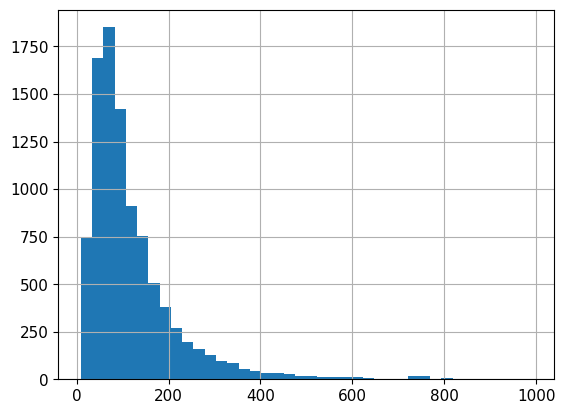

In [16]:
content.len_content.hist(bins=40)

In [17]:
content.len_content.value_counts().sort_index()

9      1
11     3
13     4
14     2
15     2
      ..
829    1
855    1
944    1
968    1
990    1
Name: len_content, Length: 537, dtype: int64

In [18]:
content[content.len_content == 11].iloc[0]['content']

'О поощрении'

In [19]:
content.describe()

,len_content
count,9528.000000
mean,120.104744
std,101.749506
min,9.000000
25%,58.000000
50%,90.000000
75%,148.000000
max,990.000000


In [20]:
# df_content

In [21]:
# Функции для извлечения текста без переделки основного pipeline

from typing import IO, Union, Optional
from pdf2image import convert_from_path
from pytesseract import pytesseract
import re


def get_text_by_coords(CLASSES, labels, image):
    predicts = []
    for bbox in labels:

        cropped = image.crop(bbox[1:-1])        
        if  bbox[-1] < 0.8:
            continue
            
        text = pytesseract.image_to_string(cropped, lang="rus")
        predict_text = re.sub('\n', ' ',text)
        predict_text = predict_text.strip()
        predicts.append(predict_text)
    pred = ' '.join(predicts)
    return pred

def get_text_predicts(pdf_file: Union[Path, IO[bytes]], 
                      model_predict_classes: YOLO,
                      model_content: YOLO,
                      CLASSES: list) -> list:

    
    if isinstance(pdf_file, Path):
        images = convert_from_path(pdf_file, fmt='.jpeg', last_page=10)
    elif isinstance(pdf_file, bytes):
        images = convert_from_bytes(pdf_file, fmt=".jpg", last_page=10)
    else:
        raise TypeError('unknown format of file')
        
    predicts_on_pages = []
    
    for num, page in enumerate(images):
        predict = model_predict_classes(page)
        labels = yolo.get_bboxes(predict)
        # если классов на странице не найдено, переход к следующей странице
        if not labels or len(labels) == 0:
            continue
        predict_text = model_content(page)
        text_labels = yolo.get_bboxes(predict_text)
        if not text_labels or len(text_labels) == 0:
            continue
        predicts_on_pages.append(get_text_by_coords(CLASSES, text_labels, page))
#         print(text_labels)
        if yolo.check_signer(labels):
            break
    return ' '.join(predicts_on_pages)
                                
                                

In [22]:
CLASSES = ['text']
path = Path(PATH_TO_DETECT_PDF)
all_paths = search_pdf_by_path(path)
# all_paths = all_paths[:1000]
len(all_paths)


3436

In [23]:
texts = {}
counter = 0
for path in all_paths:
    doc_id = path.parents[0].name.split('.')[0]
    texts[doc_id] = get_text_predicts(path,model_predict_classes, model_content, CLASSES )
#     texts.append(get_text_predicts(path,model_predict_classes, model_content, CLASSES ))
    counter += 1
    print(f'in process: {counter}/{len(all_paths)}')


0: 640x480 1 date, 1 number, 1 sender, 1 signer, 135.5ms
Speed: 1.0ms preprocess, 135.5ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 107.9ms
Speed: 0.4ms preprocess, 107.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


in process: 1/3436



0: 640x480 2 senders, 1 signer, 108.7ms
Speed: 0.3ms preprocess, 108.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 103.6ms
Speed: 0.3ms preprocess, 103.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


in process: 2/3436



0: 640x480 1 content, 1 date, 1 number, 1 sender, 1 signer, 106.9ms
Speed: 0.3ms preprocess, 106.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 106.5ms
Speed: 0.3ms preprocess, 106.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)



in process: 3/3436


0: 640x480 (no detections), 103.0ms
Speed: 0.3ms preprocess, 103.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


in process: 4/3436



0: 640x480 1 date, 1 number, 2 senders, 105.2ms
Speed: 0.3ms preprocess, 105.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 105.0ms
Speed: 0.3ms preprocess, 105.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 (no detections), 104.1ms
Speed: 0.3ms preprocess, 104.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 sender, 103.6ms
Speed: 0.3ms preprocess, 103.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 106.5ms
Speed: 0.3ms preprocess, 106.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 (no detections), 103.1ms
Speed: 0.3ms preprocess, 103.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 sender, 105.7ms
Speed: 0.3ms preprocess, 105.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 (no detections), 106.1ms
Speed: 0.3ms preprocess, 106.1ms infer

in process: 5/3436


0: 640x480 1 date, 1 number, 1 sender, 1 signer, 104.5ms
Speed: 0.3ms preprocess, 104.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 103.6ms
Speed: 0.3ms preprocess, 103.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


in process: 6/3436



0: 640x480 1 date, 1 number, 1 sender, 103.3ms
Speed: 0.3ms preprocess, 103.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 103.6ms
Speed: 0.3ms preprocess, 103.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 (no detections), 107.1ms
Speed: 0.3ms preprocess, 107.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 (no detections), 107.1ms
Speed: 0.3ms preprocess, 107.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 signer, 106.9ms
Speed: 0.3ms preprocess, 106.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 (no detections), 107.0ms
Speed: 0.3ms preprocess, 107.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)


in process: 7/3436



0: 640x480 1 content, 1 date, 1 number, 3 senders, 104.1ms
Speed: 0.3ms preprocess, 104.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 107.8ms
Speed: 0.3ms preprocess, 107.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 signer, 109.1ms
Speed: 0.3ms preprocess, 109.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 106.7ms
Speed: 0.3ms preprocess, 106.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


in process: 8/3436



0: 640x480 1 date, 1 number, 1 sender, 1 signer, 103.8ms
Speed: 0.3ms preprocess, 103.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 103.7ms
Speed: 0.3ms preprocess, 103.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


in process: 9/3436



0: 640x480 1 content, 1 date, 1 number, 1 sender, 108.9ms
Speed: 0.3ms preprocess, 108.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 108.4ms
Speed: 0.3ms preprocess, 108.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 signer, 105.1ms
Speed: 0.3ms preprocess, 105.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 103.7ms
Speed: 0.3ms preprocess, 103.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


in process: 10/3436



0: 640x480 1 content, 1 date, 1 number, 1 sender, 103.5ms
Speed: 0.3ms preprocess, 103.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 102.9ms
Speed: 0.3ms preprocess, 102.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 (no detections), 104.6ms
Speed: 0.3ms preprocess, 104.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 sender, 1 signer, 103.8ms
Speed: 0.3ms preprocess, 103.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 106.6ms
Speed: 0.3ms preprocess, 106.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


in process: 11/3436



0: 640x480 1 content, 1 date, 1 number, 1 sender, 1 signer, 104.5ms
Speed: 0.3ms preprocess, 104.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 104.0ms
Speed: 0.3ms preprocess, 104.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


in process: 12/3436



0: 640x480 1 date, 1 number, 1 sender, 105.0ms
Speed: 0.4ms preprocess, 105.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 104.2ms
Speed: 0.3ms preprocess, 104.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 (no detections), 109.1ms
Speed: 0.3ms preprocess, 109.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 3 signers, 106.7ms
Speed: 0.3ms preprocess, 106.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 110.2ms
Speed: 0.3ms preprocess, 110.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


in process: 13/3436



0: 640x480 1 date, 1 number, 2 senders, 1 signer, 103.1ms
Speed: 0.3ms preprocess, 103.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 103.5ms
Speed: 0.3ms preprocess, 103.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)



in process: 14/3436


0: 640x480 1 content, 1 date, 1 number, 1 sender, 1 signer, 102.9ms
Speed: 0.3ms preprocess, 102.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 104.1ms
Speed: 0.3ms preprocess, 104.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)



in process: 15/3436


0: 640x480 1 content, 1 date, 1 number, 1 sender, 1 signer, 107.3ms
Speed: 0.3ms preprocess, 107.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 text, 109.4ms
Speed: 0.3ms preprocess, 109.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


in process: 16/3436


KeyboardInterrupt: 

In [ ]:
predicts = pd.DataFrame.from_dict(texts, orient='index').reset_index()
predicts.rename(columns={'index':'doc_id', 0: 'text'}, inplace=True)

In [ ]:
df_content = predicts.merge(content, on='doc_id')
df_content = df_content[df_content.kind == 'Письмо']

In [ ]:
df_content = df_content[df_content.len_content > 60]
df_content['len_text'] = df_content['text'].agg(len)
df_content.rename(columns={'content': 'summary'}, inplace=True)

In [ ]:
df_content['text'] = df_content['text'].apply(lambda row: None if row == '' else row)
df_content.dropna(inplace=True)

In [ ]:
df_content.shape

In [ ]:
df_content.to_pickle('/local_data/data/df_summary.pickle')

In [ ]:
df_content['len_text'].hist()

In [ ]:
df_content.describe()

In [ ]:
'/local_data/clear_full/000f2cdf-e009-4c51-aaf7-dfda85f9d3d0/'

In [24]:
xx = '/local_data/clear_full/078a3af5-f7d5-4675-9b14-cd7040e5e95c/73dedc08-ad69-41f5-9b56-c676d3dc7521.pdf'

In [25]:
yolo.open_pdf(xx)